# Recolorization Project
The purpose of the project is to add colors to a grayscale image, knowing the mean intensity of red, green and blue in the expected image.
The proposed architecture is a U-net with residual blocks.
The conidtioning is performed with AdaIn like in the styleGAN architecture. As a design choice, I decided to change the learning objective, converting the images from the RGB space to the Lab space. In this way, the Network is responsible only to learn the chromicity, while the intensity and geometric information are preserved in the Gray image.

## The coloring problem

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import tensorflow_datasets as tfds

We work on the oxford flower dataset

In [ ]:
def load_flowers_dataset(num_samples=1000, img_size=128):
    ds = tfds.load('oxford_flowers102', split='train', shuffle_files=True)
    ds = ds.map(lambda x: tf.image.resize(x['image'], (img_size, img_size)) / 255.0)
    ds = ds.take(num_samples).batch(num_samples)
    images = next(iter(ds)).numpy()
    return images

In [ ]:
# === CONFIGURATION ===
IMG_SIZE = 128
BATCH_SIZE = 32
NUM_TRAIN = 6149

Let us slightly reduce the resolution

In [ ]:
def preprocess_image(sample):
    """Resize and normalize image"""
    image = tf.image.resize(sample['image'], (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Dataset manipulation


## Generator

It returns the tuple **[(gray image, condition vector) , ab true channels]**.

As I said, the training is performed in the Lab color space. For inference, it is necessary to concatenate the gray image to the predicted ab channels and then change color space, coming back to the RGB space.


In [ ]:
# === DATA GENERATOR ===
def batch_cvtColor(images, code):
    '''Convert a batch of images from a color representation to another one using the opencv color code '''
    def cvt(images_np):
        return np.array([cv2.cvtColor((img * 255).astype(np.uint8), code)/ 255.0 for img in images_np] , dtype=np.float32)
    return tf.numpy_function(cvt, [images], tf.float32)

class GrayScaleGenerator(tf.keras.utils.Sequence):
    def __init__(self, palette, lab_images, batch_size=32, shuffle=True):
        self.palette = palette
        self.lab_images = lab_images
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(lab_images))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return len(self.lab_images) // self.batch_size

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_palette = self.palette[batch_indices]
        batch_lab = self.lab_images[batch_indices]

        batch_gray = batch_lab[:,:,:,0]
        batch_gray = np.expand_dims(batch_gray, axis=-1)

        ab_channel = batch_lab[:,:,:,1:3]
        return (batch_gray, batch_palette), ab_channel

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [ ]:
# === LOAD & SPLIT FLOWER DATA ===
def load_flower_dataset_splits():
    ds_train = tfds.load('oxford_flowers102', split='test', shuffle_files=True)
    ds_val = tfds.load('oxford_flowers102', split='validation', shuffle_files=True)
    ds_test = tfds.load('oxford_flowers102', split='train', shuffle_files=True)
    ds_train = tf.stack(list(ds_train.map(preprocess_image)))
    ds_val = tf.stack(list(ds_val.map(preprocess_image)))
    ds_test = tf.stack(list(ds_test.map(preprocess_image)))
    return (ds_train,ds_val,ds_test)

def augment_dataset(X, augment_factor=2, **datagen_kwargs):
    ''' function for data augmentation, the augment_factor is a the size multiplier of the original dataset'''
    datagen = ImageDataGenerator(**datagen_kwargs)
    N = X.shape[0]
    X_aug_list = []

    for i in range(N):
        img = X[i:i+1]  # shape (1, H, W, C)
        aug_iter = datagen.flow(img, batch_size=1, shuffle=False)
        for _ in range(augment_factor-1):
            aug_img = next(aug_iter)[0]
            X_aug_list.append(aug_img)

    X_new = np.concatenate([X] + [np.stack(X_aug_list)], axis=0)
    return X_new

In [ ]:
# Load and split the dataset
train_imgs, val_imgs, test_imgs = load_flower_dataset_splits()

train_imgs = train_imgs.numpy()
val_imgs = val_imgs.numpy()
test_imgs = test_imgs.numpy()


## Data aumentation

To increase the dataset and to give the network more invariance with respect to noise and geometric translation, we use data augmentation. This should be usefull also to prevent overfitting of the network since the original dataset is quite small.

In [ ]:

augment = False

if augment:
  X_aug = augment_dataset(
      train_imgs,
      augment_factor=3,
      rotation_range=15,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.05,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest'
  )
else:
  X_aug = train_imgs

In [ ]:
print(f"Original shape: {train_imgs.shape}")
print(f"Augmented shape: {X_aug.shape}")

palette_train = np.mean(X_aug, axis=(1,2))
palette_val = np.mean(val_imgs, axis=(1,2))
palette_test = np.mean(test_imgs, axis=(1,2))

lab_train = np.array([cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2LAB)/ 255.0 for img in X_aug] , dtype=np.float32)
lab_val = np.array([cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2LAB)/ 255.0 for img in val_imgs] , dtype=np.float32)
lab_test = np.array([cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2LAB)/ 255.0 for img in test_imgs] , dtype=np.float32)

train_gen = GrayScaleGenerator(palette_train, lab_train, batch_size=BATCH_SIZE)
val_gen = GrayScaleGenerator(palette_val, lab_val, batch_size=BATCH_SIZE)
test_gen = GrayScaleGenerator(palette_test, lab_test, batch_size=BATCH_SIZE)

Original shape: (6149, 128, 128, 3)
Augmented shape: (6149, 128, 128, 3)


As reference we define a simple baseline, where we uniformly distribute colors according to the given input palette. This will be the reference model to check performances of our network

In [ ]:
def baseline(gray,palette):
  gray = np.squeeze(gray, axis=-1)
  m = np.mean(gray, axis=(1,2))
  red = gray*(palette[:,0]/m)[:, np.newaxis, np.newaxis]
  green = gray*(palette[:,1]/m)[:, np.newaxis, np.newaxis]
  blue = gray*(palette[:,2]/m)[:, np.newaxis, np.newaxis]
  return np.stack([red,green,blue],axis=-1)

Let us visualize a few examples.

(32, 128, 128, 1)


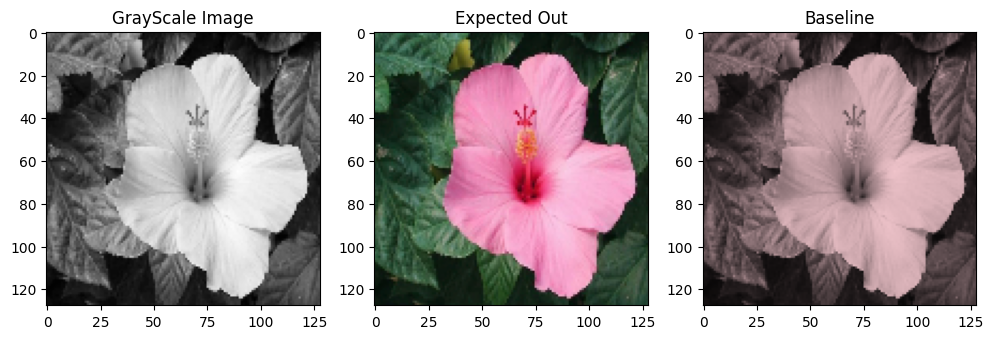

In [ ]:
# Sanity check
idx = np.random.randint(0, len(test_gen) - 1)
(x_gray , x_palette), y = test_gen[idx]
print(x_gray.shape)

y = np.concatenate([x_gray,y],axis=-1)
y = batch_cvtColor(y, cv2.COLOR_LAB2RGB)

baseline_out = baseline(x_gray,x_palette)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(x_gray[0],cmap='gray')
plt.title("GrayScale Image")

plt.subplot(1, 3, 2)
plt.imshow(y[0])
plt.title("Expected Out")

plt.subplot(1, 3, 3)
plt.imshow(baseline_out[0])
plt.title("Baseline")
plt.show()

The objective is to improve over the baseline.

Let us compute the error of the baseline on a batch of data. The used metric is the Mean Squared Error. Before we compute the mse over the spatial dimension, then we perform mse over the batch dimension and channel dimension.

In [ ]:
idx = np.random.randint(0, len(test_gen) - 1)
(x_gray,x_palette), y = test_gen[idx]

y = np.concatenate([x_gray,y],axis=-1)
y = batch_cvtColor(y, cv2.COLOR_LAB2RGB)

baseline_out = baseline(x_gray,x_palette)
baseline_mse_batch = np.mean((baseline_out - y)**2,axis=(1,2))
baseline_mse = np.mean(baseline_mse_batch)
print(f"Baseline MSE: {baseline_mse:.4f}")

Baseline MSE: 0.0079


# Definition of the Network

The architecture I chose is a **Conditioned Residual U-Net**.  
In particular, I decided to implement **Adaptive Instance Normalization (AdaIN)** layers to inject style information into the network.  
Moreover, instead of the traditional convolutional layers used in the original U-Net, I employed **Residual Blocks**, which enable a more stable and efficient training process.  

---

## AdaIN
Adaptive Instance Normalization (AdaIN) is a normalization technique widely used in style transfer and generative models.  
In this architecture, AdaIN layers are applied to condition the decoder on global color information. The idea is to separate **content** (grayscale input features extracted by the encoder) from **style** (color embeddings provided as conditioning input).  
By applying AdaIN to feature maps in the decoder, the network can adjust the mean and variance of its activations according to the target color style, leading to more realistic and coherent colorization results.  

---

## Residual Block
Residual Blocks replace the standard convolutional layers of the U-Net.  
A residual block applies two convolutional layers and then adds the input (shortcut) directly to the output of these operations.

The main advantages of residual blocks are:  
- **Stable training:** they mitigate the vanishing gradient problem.  
- **Better gradient flow:** residual connections allow information to pass through the network without degradation.  
- **Flexibility:** they make it possible to increase the network depth without compromising convergence.  


In [ ]:
from tensorflow import keras
from keras.layers import Layer, Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, UpSampling2D
from keras.layers import BatchNormalization, Dense, Activation, Add, Multiply, Resizing, Reshape, LeakyReLU, LayerNormalization

from keras.models import Model
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

import os
import gdown

weights_path = "weights/"
os.makedirs(weights_path, exist_ok=True)

# ==== FUNCTIONS =============

# =========================================================
# Mapping network: from condition to w
# =========================================================
def build_mapping_network(cond_dim=3, w_dim=128, n_layers=3):
    '''
      Map the condition vector in a more large space representation
        - cond_dim : dimension of the condition
        - w_dim : dimension of the embedded output
        - n_layers : Number of consecutive Fully Connected Layers

      The function returns a TF model
    '''
    cond_input = Input((cond_dim,))
    x = cond_input
    for _ in range(n_layers):
        x = Dense(w_dim, activation="relu")(x)

    return Model(cond_input, x, name="MappingNetwork")
# =========================================================
# Residual Block
# =========================================================
def residual_block(x, filters, w=None, kernel_size=3, style_dim=128):
    '''
      Residual block implementation
        - x : input of the block
        - filters : channel dimension of the output (number of filters)
        - w : conditioning vector for AdaIn (not mandatory, alternative is BatchNormalization)
        - kernel_size : size of the convolution kernel
        - style_dim : Dimension of the conditioning vector

        Returns the output activation
    '''

    shortcut = x
    shortcut = Conv2D(filters, (1,1), strides=(1,1), padding='same')(shortcut)

    x = Conv2D(filters, kernel_size, strides=(1,1), padding='same')(x)
    if w == None: x = BatchNormalization()(x)
    else: x = AdaIN(style_dim)([x, w])
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size, strides=(1,1), padding='same')(x)
    if w == None: x = BatchNormalization()(x)
    else: x = AdaIN(style_dim)([x, w])

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# =========================================================
# Adaptive Instance Normalization (AdaIN)
# =========================================================
class AdaIN(Layer):
    '''
      Adaptive Istance Normalization layer implementation
    '''
    def __init__(self, style_dim):
        super(AdaIN, self).__init__()
        self.style_dim = style_dim

    def build(self, input_shape):
        c = input_shape[0][-1]  # number of channels
        # Dense layer per gamma e beta
        self.fc_gamma = Dense(c)
        self.fc_beta  = Dense(c)

    def call(self, inputs):
        x, w = inputs  # x: feature map, w: style vector
        # Mean and Variance along H and W

        mean, var = tf.nn.moments(x, axes=[1,2], keepdims=True)
        epsilon = 1e-5
        x_norm = (x - mean) / tf.sqrt(var + epsilon)

        gamma = self.fc_gamma(w)
        beta  = self.fc_beta(w)
        gamma = tf.reshape(gamma, (-1,1,1,x.shape[-1])) # the learned variance
        beta  = tf.reshape(beta, (-1,1,1,x.shape[-1])) # the learned mean

        return gamma * x_norm + beta

# =========================================================
# Down block for the encoder of the U-net
# =========================================================
def down_block(inputs, filters, kernel_size=(3, 3)):
    '''
      Down block for the U-net
        - inputs : input of the block
        - filters : channel dimension of the output (number of filters)
        - kernel_size : size of the convolution kernel

        Returns the output activation
    '''
    conv = residual_block(inputs, filters, kernel_size=kernel_size)

    pool = MaxPooling2D(pool_size=(2, 2))(conv)
    pool = Dropout(0.2)(pool)
    return conv, pool

# =========================================================
# Up block for the decoder of the U-net
# =========================================================
def up_block(inputs, skip, w, filters, kernel_size=(3, 3), style_dim=128):
    '''
      Up block for the U-net
        - inputs : input of the block
        - skip : skip connection from a layer in the encoder with same spatial dimension
         - w : conditioning vector for AdaIn (not mandatory, alternative is BatchNormalization)
        - filters : channel dimension of the output (number of filters)
        - kernel_size : size of the convolution kernel
        - style_dim : Dimension of the conditioning vector

        Returns the output activation
    '''
    # Up sampling
    x = UpSampling2D(size=(2,2), interpolation="nearest")(inputs)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = AdaIN(style_dim)([x, w])
    x = Activation('relu')(x)

    x = concatenate([x, skip], axis=3)
    x = AdaIN(style_dim)([x, w])
    x = Activation('relu')(x)
    #x = Dropout(0.2)(x)
    x = residual_block(x, filters, kernel_size=kernel_size, w=w, style_dim=style_dim)

    return x

def color_vector_embedding(input, color_palette, emb_dim):
    #color_emb = Dense(emb_dim, activation="relu")(color_palette)
    color_emb = Reshape((1,1,emb_dim))(color_palette)

    def tile_to_match(x):
        color, input = x
        return tf.tile(color, [1, tf.shape(input)[1], tf.shape(input)[2], 1])

    color_emb = layers.Lambda(tile_to_match)([color_emb, input])

    return concatenate([input, color_emb])

# =========================================================
# AUX functions for visualization
# =========================================================

def plot_metrics(history):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))

    axes[0].plot(history.history['loss'], color='blue')
    axes[0].set_title("loss - mse")
    axes[0].set_xlabel("Epoch")
    axes[0].grid(True)

    axes[1].plot(history.history['accuracy'], color='red')
    axes[1].set_title("accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].grid(True)

    axes[2].plot(history.history['mean_ratio'], color='green')
    axes[2].set_title("mean_ratio")
    axes[2].set_xlabel("Epoch")
    axes[2].grid(True)

    axes[3].plot(history.history['val_loss'], color='orange')
    axes[3].set_title("val_loss")
    axes[3].set_xlabel("Epoch")

    plt.tight_layout()
    plt.show()

## Network Architecture: Simple U-Net (Conditioned)

The network is a variant of a **Conditioned U-Net**, designed for image colorization in the **Lab color space**.  
The input consists of:  
- A grayscale image (`L` channel).  
- A conditioning vector (average color, dimension 3).  

### 1. Input
- **Gray-scale input:** image of size `(IMG_SIZE, IMG_SIZE, 1)`  
- **Color conditioning input:** vector of size `(3,)`  

### 2. Mapping Network (Conditioning)
- **3 Dense layers** with `256` units each (ReLU activation)  
- Output: style vector `w` of dimension `256`  

### 3. Encoder
Each `down_block` contains a **Residual Block** + **MaxPooling + Dropout**.  

- **Down Block 1**  
  - Residual Block (32 filters, 3×3 kernel)  
  - MaxPooling 2×2 + Dropout  

- **Down Block 2**  
  - Residual Block (64 filters, 3×3 kernel)  
  - MaxPooling 2×2 + Dropout  

- **Down Block 3**  
  - Residual Block (128 filters, 3×3 kernel)  
  - MaxPooling 2×2 + Dropout  

### 4. Bottleneck
- **Residual Block** with 256 filters (3×3 kernel), conditioned with **AdaIN**  
- **Color Vector Embedding**: concatenates the features with a color conditioning embedding  

### 5. Decoder
Each `up_block` contains:  
- **Upsampling 2×2**  
- **Attention Gate** on the skip connection  
- **Residual Block** conditioned with AdaIN  

- **Up Block 1**  
  - Input: bottleneck + skip from encoder (128 filters)  
  - Output: 128 feature maps  

- **Up Block 2**  
  - Input: previous up_block + skip from encoder (64 filters)  
  - Output: 64 feature maps  

- **Up Block 3**  
  - Input: previous up_block + skip from encoder (32 filters)  
  - Output: 32 feature maps  

### 6. Output Layer
- **Final Conv2D** with 2 filters (3×3 kernel, sigmoid activation)  
- Output: map of **a, b** components (Lab color space)  


In [ ]:
def simple_unet():
    # Inputs

    gray_in = Input((IMG_SIZE, IMG_SIZE, 1), name="gray_scale_input")
    color_in = Input((3,), name="color_mean_input")

    # Mapping network for conditioning
    mapping_net = build_mapping_network(3, 256, 3)
    w = mapping_net(color_in)

    # Encoder
    conv1, pool1 = down_block(gray_in, filters=32)
    conv2, pool2 = down_block(pool1, filters=64)
    conv3, pool3 = down_block(pool2, filters=128)

    # bottleneck
    conv5 = residual_block(pool3, filters=256, w=w,  style_dim=256)

    # Decoder
    conv7 = up_block(conv5, conv3, w, filters=128, style_dim=256)
    conv8 = up_block(conv7, conv2, w, filters=64, style_dim=256)
    conv9 = up_block(conv8, conv1, w, filters=32, style_dim=256)

    # Output (a,b channels)
    out = Conv2D(2, (3, 3), activation='sigmoid', padding='same', name='output_ab')(conv9)

    return Model([gray_in, color_in], out, name="Generator")

# Loss function

The chosen loss function is the **Mean Squared Error (MSE)**, which proved to work well for this problem.  
MSE is suitable because it directly measures the pixel-wise difference between the predicted *a,b* channels and the ground truth values in the Lab space. This enforces the network to minimize large deviations in color prediction and stabilizes training.  

Future extensions could explore hybrid objectives, for example combining MSE with **adversarial loss** to enhance realism and perceptual quality of the generated colorizations.


In [ ]:
# =============================
# Callbacks
# =============================

class MeanRatioCallback(tf.keras.callbacks.Callback):
    '''
      TF callback to print the evaluation matric at every epoch
      This is the same evaluation metric used for scoring the exam, computed over the test set
    '''
    def __init__(self, test_gen, mymodel):
        super().__init__()
        self.test_gen = test_gen
        self.mymodel = mymodel

    def on_epoch_end(self, epoch, logs=None):
      # Collect the metric for every test batch
      mean_ratio = []

      for idx in range(len(self.test_gen)):
        (x_gray,x_palette), y =  self.test_gen[idx]

        # From Lab space to RGB (true image)
        y = np.concatenate([x_gray,y],axis=-1)
        y = batch_cvtColor(y, cv2.COLOR_LAB2RGB)

        # Reference model
        baseline_out = baseline(x_gray,x_palette)
        baseline_mse_batch = np.mean((baseline_out - y)**2,axis=(1,2))
        baseline_mse = np.mean(baseline_mse_batch)

        # From Lab space to RGB (predicted image)
        predicted_ab =  self.mymodel.predict([x_gray, x_palette])

        generated_images = np.concatenate([x_gray,predicted_ab],axis=-1)
        generated_images = batch_cvtColor(generated_images, cv2.COLOR_LAB2RGB)

        # Compute the distance between generated image and original for the batch
        generated_mes_batch = np.mean((generated_images - y)**2,axis=(1,2))
        # Now let us compute the ratio, and the average over the batch
        mean_ratio.append(np.mean(generated_mes_batch/baseline_mse_batch))

      total_mean = np.mean(mean_ratio)
      std_dev = np.std(mean_ratio)

      print(f"Epoch {epoch+1}: Total Average score (Generated / Initial): {total_mean:.4f}")
      print(f"Epoch {epoch+1}: Total Standard Deviation score (Generated / Initial): {std_dev:.4f}")

      if logs is not None:
          logs['mean_ratio'] = total_mean
          logs['std_dev'] = std_dev

In [ ]:
# =============================
# Compile
# =============================

# Learning rate
LEARNING_RATE = 1e-3
DECAY_FACTOR = 0.75
STEP_LR = 4

unet_model = simple_unet()
mean_ratio_cb = MeanRatioCallback(
    test_gen=test_gen,
    mymodel=unet_model
    )

checkpoint = ModelCheckpoint(
    filepath="/kaggle/working/model_best_mse_v2.h5",
    monitor="mean_ratio",
    save_best_only=True
)

u_opt = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE, beta_1=0.5)

def step_decay_schedule(initial_lr, decay_factor, step_size):
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    return LearningRateScheduler(schedule)

LR_SCHEDULE = step_decay_schedule(initial_lr=LEARNING_RATE, decay_factor=DECAY_FACTOR, step_size=STEP_LR)

unet_model.compile(optimizer=u_opt, loss='mse', metrics=["accuracy"])

unet_model.summary()



Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ gray_scale_input    │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │        320 │ gray_scale_input… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │         64 │ gray_scale_input… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      2,112 │ dropout[0][0]   

 Total params: 3,200,610 (12.21 MB)

 Trainable params: 3,199,714 (12.21 MB)

 Non-trainable params: 896 (3.50 KB)

The total number of trainable parameters is 3,199,714 that is under the project constraint of 5M parameters.

In [ ]:
# =============================
# Training
# =============================

EPOCHS = 40

save = False
Train = False

if Train :
  history = unet_model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS, callbacks = [mean_ratio_cb, LR_SCHEDULE, checkpoint])
  plot_metrics(history)

else :
  model_path = os.path.join(weights_path, "model_best.h5")

  # Download the weights with gdown
  if not os.path.exists(model_path):
    link_id = "1QPj47bJg1YwFltrDUGllq_v3QjD_a7Gg"
    gdown.download(f"https://drive.google.com/uc?id={link_id}", model_path, quiet=False)
    print(f"Downloaded model weights from Google Drive")

  # Load the model weights
    unet_model.load_weights(model_path)
    print(f"Loaded model weights from {model_path}")

# if save == True:
#   unet_model.save_weights("/content/drive/MyDrive/samori_net.weights.h5")

Downloading...
From: https://drive.google.com/uc?id=1QPj47bJg1YwFltrDUGllq_v3QjD_a7Gg
To: /content/weights/model_best.h5
100%|██████████| 38.8M/38.8M [00:00<00:00, 61.3MB/s]


Downloaded model weights from Google Drive
Loaded model weights from weights/model_best.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


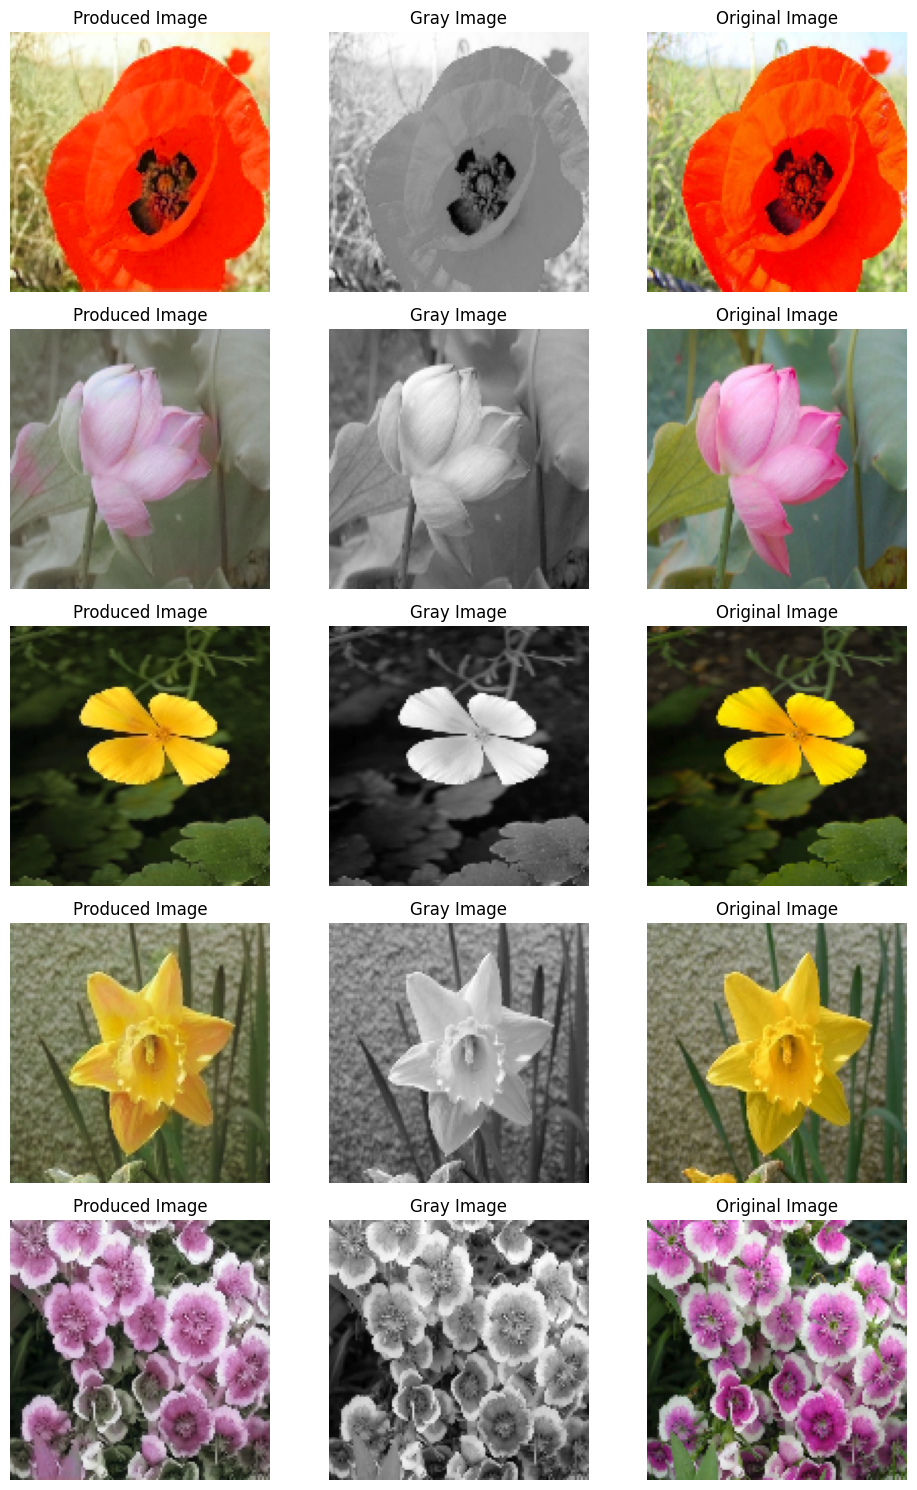

In [ ]:
generated_images = unet_model.predict((x_gray,x_palette))

generated_images = np.concatenate([x_gray,generated_images],axis=-1)
generated_images = batch_cvtColor(generated_images, cv2.COLOR_LAB2RGB)

generated_images = generated_images[:,:,:,0:3]

num_examples = 5
indices = np.random.choice(BATCH_SIZE, size=num_examples, replace=False)

plt.figure(figsize=(10, 3 * num_examples))

for i, indx in enumerate(indices):
    # Produced image
    plt.subplot(num_examples, 3, i * 3 + 1)
    plt.imshow(generated_images[indx])
    plt.title("Produced Image")
    plt.axis("off")

    # Gray input
    plt.subplot(num_examples, 3, i * 3 + 2)
    plt.imshow(x_gray[indx].squeeze(), cmap='gray')
    plt.title("Gray Image")
    plt.axis("off")

    # Original
    plt.subplot(num_examples, 3, i * 3 + 3)
    plt.imshow(y[indx])
    plt.title("Original Image")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Evaluation metric


The baseline error is already quite low. To better emphasize the correction we compute the ratio between the resulting error and the baseline one.
**This should be a value between 0 (perfect reconstruction) and 1 (no reconstruction). Higher values mean you are doing things worse.**

In [ ]:
# Collect the metric for every test batch
mean_ratio = []

for idx in range(len(test_gen)):
  (x_gray,x_palette), y = test_gen[idx]

  # From Lab space to RGB (true image)
  y = np.concatenate([x_gray,y],axis=-1)
  y = batch_cvtColor(y, cv2.COLOR_LAB2RGB)

  baseline_out = baseline(x_gray,x_palette)
  baseline_mse_batch = np.mean((baseline_out - y)**2,axis=(1,2))
  baseline_mse = np.mean(baseline_mse_batch)
  print(f"Baseline MSE: {baseline_mse:.4f}")

  # From Lab space to RGB (predicted image)
  predicted_ab =  unet_model.predict([x_gray, x_palette])
  generated_images = np.concatenate([x_gray,predicted_ab],axis=-1)
  generated_images = batch_cvtColor(generated_images, cv2.COLOR_LAB2RGB)

  # Compute the distance between generated image and original for the batch
  generated_mes_batch = np.mean((generated_images - y)**2,axis=(1,2))
  # Now let us compute the ratio, and the average over the batch
  mean_ratio.append(np.mean(generated_mes_batch/baseline_mse_batch))
  print(f"--- Average score (Generated / Initial): {mean_ratio[idx]:.4f}")

total_mean = np.mean(mean_ratio)
std_dev = np.std(mean_ratio)

print()
print()
print(f"Total Average score (Generated / Initial): {total_mean:.4f}")
print(f"Total Standard Deviation score (Generated / Initial): {std_dev:.4f}")

Baseline MSE: 0.0095
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
--- Average score (Generated / Initial): 0.6968
Baseline MSE: 0.0141
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
--- Average score (Generated / Initial): 0.7412
Baseline MSE: 0.0125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
--- Average score (Generated / Initial): 0.6449
Baseline MSE: 0.0115
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
--- Average score (Generated / Initial): 0.6925
Baseline MSE: 0.0111
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
--- Average score (Generated / Initial): 0.5134
Baseline MSE: 0.0105
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
--- Average score (Generated / Initial): 0.6748
Baseline MSE: 0.0098
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
--- Average score (Generated / Initial): 0.6806
Baseline MSE: 0.0155
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
--- Average score (Generated / Initial): 0.7676
Baseline MSE: 0.0125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
--- Average score (Generated / Initial): 0.6044
Baseline MSE: 0.0100
1/1 ━━━

In conclusion the model works well, the obtained score for the metric is:

- Average score: 0.6360
- Standard Deviation: 0.0843